<a href="https://colab.research.google.com/github/andreas31603/MachineLearningTasks/blob/main/Task14/Markov_model_dan_Hidden_Markov_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [2]:
# Periksa apakah CUDA tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Membaca dataset
file_path = 'Dataset\Occupancy_Estimation.csv'
data = pd.read_csv(file_path)

# Konversi kolom 'Date' dan 'Time' menjadi datetime
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Drop kolom yang tidak diperlukan untuk analisis dan modeling
data_cleaned = data.drop(columns=['Date', 'Time'])

# Mengecek nilai yang hilang
missing_values = data_cleaned.isnull().sum()

Using device: cuda


c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


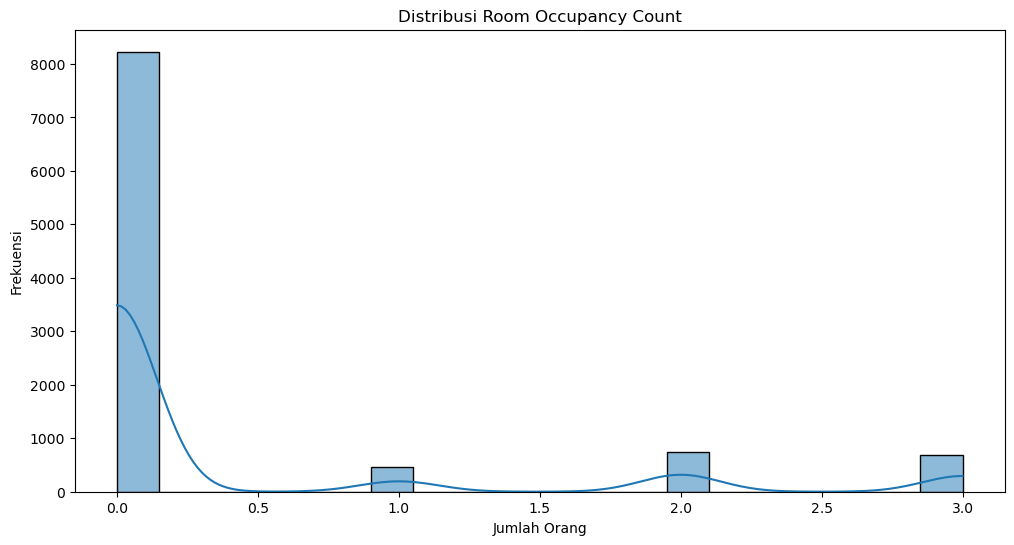

In [ ]:
# Visualisasi distribusi data untuk fitur yang relevan
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned['Room_Occupancy_Count'], bins=20, kde=True)
plt.title('Distribusi Room Occupancy Count')
plt.xlabel('Jumlah Orang')
plt.ylabel('Frekuensi')
plt.show()

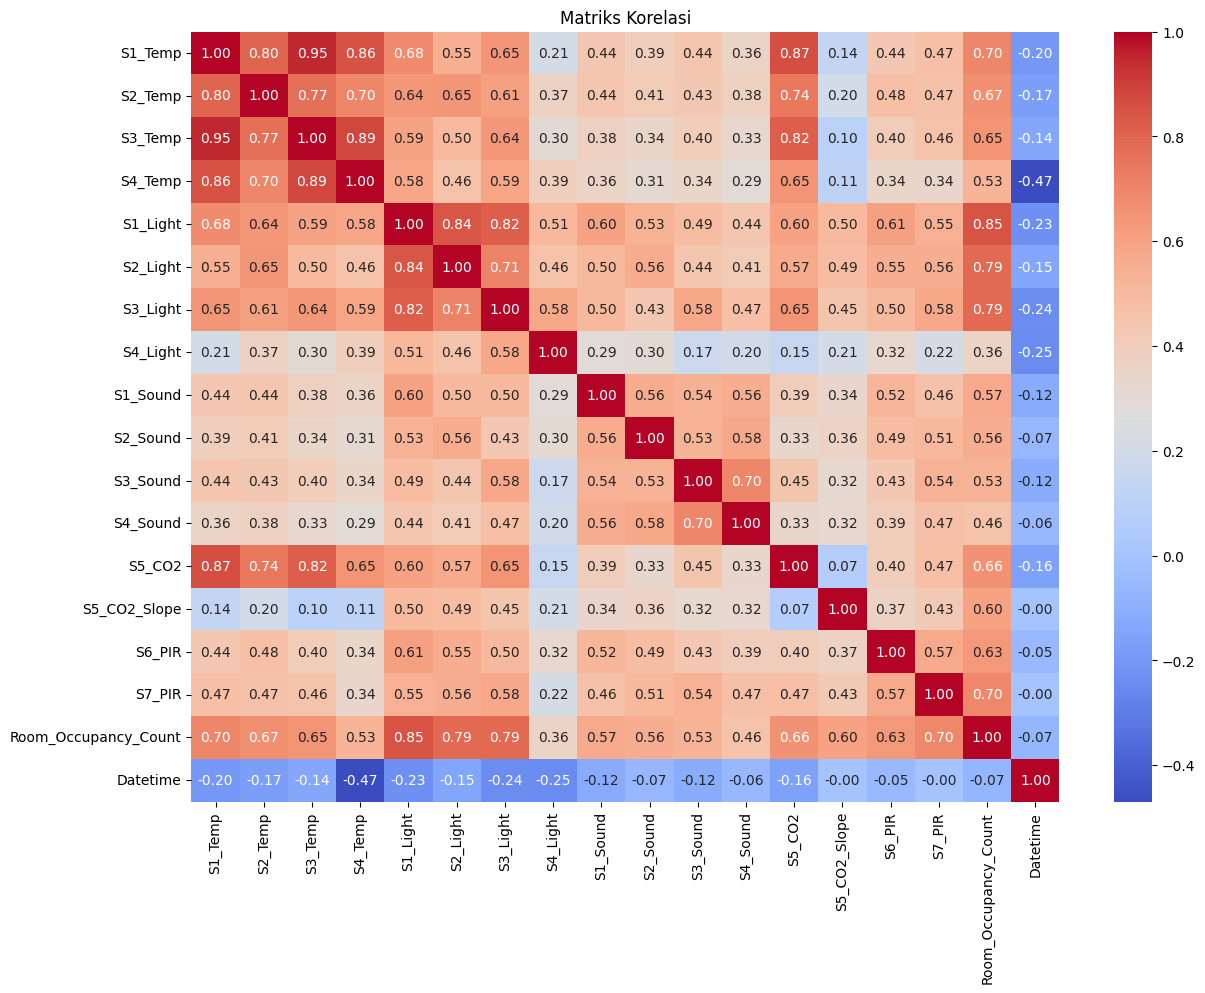

In [3]:
# Korelasi antara fitur dan target
correlation_matrix = data_cleaned.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()

In [ ]:
# Split data menjadi training dan testing
data_sequence = data_cleaned['Room_Occupancy_Count'].values
X = data_sequence[:-1]
y = data_sequence[1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi data ke tensor dan pindahkan ke perangkat yang sesuai
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [ ]:
# Hidden Markov Model menggunakan RNN
class HMMRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling=None):
        super(HMMRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == 'max':
            out, _ = torch.max(out, dim=1)
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        else:
            out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
# Fungsi pelatihan
class MarkovModel:
    def __init__(self, states):
        self.states = states
        self.transition_matrix = None

    def fit(self, data):
        # Membuat matriks transisi berdasarkan frekuensi transisi dalam data
        n_states = len(self.states)
        self.transition_matrix = np.zeros((n_states, n_states))

        for (current_state, next_state) in zip(data[:-1], data[1:]):
            self.transition_matrix[current_state, next_state] += 1

        # Normalisasi matriks transisi
        self.transition_matrix = self.transition_matrix / self.transition_matrix.sum(axis=1, keepdims=True)

    def predict_next_state(self, current_state):
        # Prediksi state berikutnya berdasarkan probabilitas
        probabilities = self.transition_matrix[current_state]
        return np.random.choice(self.states, p=probabilities)

data_sequence = data_cleaned['Room_Occupancy_Count'].values
unique_states = np.unique(data_sequence)

markov_model = MarkovModel(states=unique_states)
markov_model.fit(data_sequence)
markov_predictions = [markov_model.predict_next_state(state) for state in data_sequence[:50]]
markov_accuracy = sum(np.array(markov_predictions) == data_sequence[1:51]) / 50


In [ ]:
# Hidden Markov Model eksperimen
def train_model(hidden_size, pooling, optimizer_name, num_epochs=50):
    output_size = len(np.unique(data_sequence))
    model = HMMRNN(input_size=1, hidden_size=hidden_size, output_size=output_size, pooling=pooling).to(device)

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

    # Evaluasi
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

    return model, accuracy

In [ ]:
# Eksperimen dengan berbagai parameter
hidden_sizes = [8, 16, 32]
pooling_types = [None, 'max', 'avg']
optimizers = ['SGD', 'RMSProp', 'Adam']
epochs = [5, 50, 100, 250, 350]

results = []

for hidden_size in hidden_sizes:
    for pooling in pooling_types:
        for optimizer_name in optimizers:
            print(f'Hidden Size: {hidden_size}, Pooling: {pooling}, Optimizer: {optimizer_name}')
            _, accuracy = train_model(hidden_size=hidden_size, pooling=pooling, optimizer_name=optimizer_name, num_epochs=50)
            results.append((hidden_size, pooling, optimizer_name, accuracy))

Hidden Size: 8, Pooling: None, Optimizer: SGD
Epoch [10/50], Loss: 0.1864
Epoch [20/50], Loss: 0.1531
Epoch [30/50], Loss: 0.1396
Epoch [40/50], Loss: 0.1336
Epoch [50/50], Loss: 0.1312
Accuracy: 1.0000
Hidden Size: 8, Pooling: None, Optimizer: RMSProp
Epoch [10/50], Loss: 0.0241
Epoch [20/50], Loss: 0.0231
Epoch [30/50], Loss: 0.0225
Epoch [40/50], Loss: 0.0222
Epoch [50/50], Loss: 0.0220
Accuracy: 1.0000
Hidden Size: 8, Pooling: None, Optimizer: Adam
Epoch [10/50], Loss: 0.0691
Epoch [20/50], Loss: 0.0364
Epoch [30/50], Loss: 0.0309
Epoch [40/50], Loss: 0.0294
Epoch [50/50], Loss: 0.0289
Accuracy: 1.0000
Hidden Size: 8, Pooling: max, Optimizer: SGD
Epoch [10/50], Loss: 0.2111
Epoch [20/50], Loss: 0.1861
Epoch [30/50], Loss: 0.1747
Epoch [40/50], Loss: 0.1683
Epoch [50/50], Loss: 0.1664
Accuracy: 0.9492
Hidden Size: 8, Pooling: max, Optimizer: RMSProp
Epoch [10/50], Loss: 0.0247
Epoch [20/50], Loss: 0.0233
Epoch [30/50], Loss: 0.0227
Epoch [40/50], Loss: 0.0224
Epoch [50/50], Loss: 0.

In [ ]:

# Ekspor hasil ke CSV
results_df = pd.DataFrame(results, columns=['Hidden Size', 'Pooling', 'Optimizer', 'Accuracy'])
results_csv_path = 'results_accuracy.csv'
results_df.to_csv(results_csv_path, index=False)
print(f'Results saved to {results_csv_path}')

Results saved to results_accuracy.csv


In [ ]:
# Menampilkan 5 akurasi terbaik
top_5_results = results_df.nlargest(5, 'Accuracy')
print("Top 5 Akurasi Terbaik:")
print(top_5_results)

Top 5 Akurasi Terbaik:
   Hidden Size Pooling Optimizer  Accuracy
0            8    None       SGD       1.0
1            8    None   RMSProp       1.0
2            8    None      Adam       1.0
4            8     max   RMSProp       1.0
5            8     max      Adam       1.0


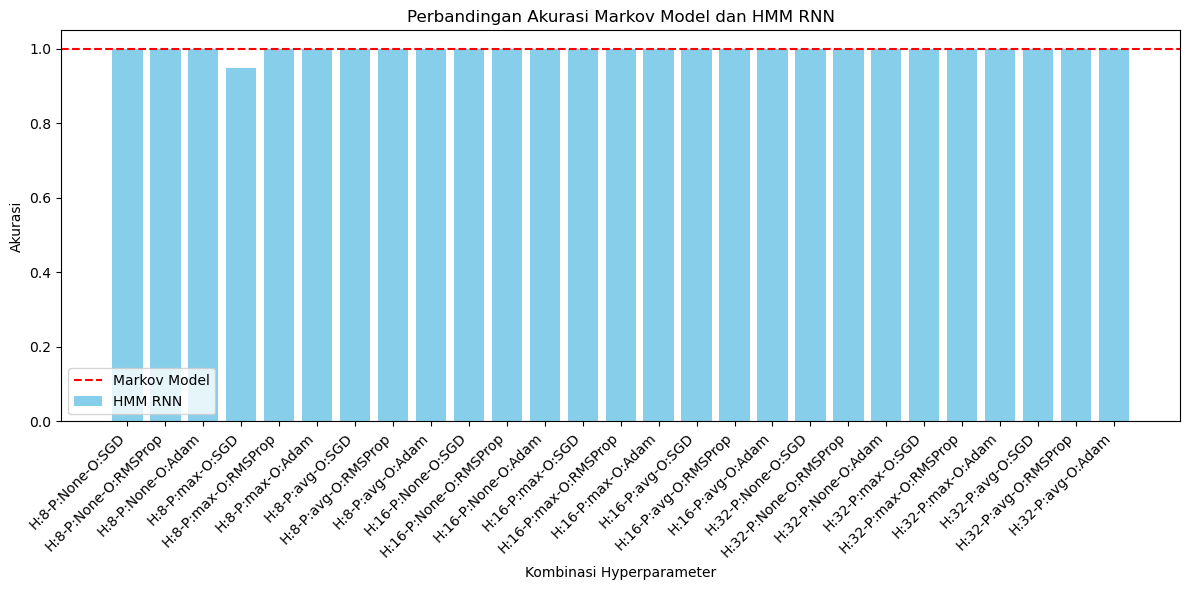

In [ ]:
# Visualisasi perbandingan hasil
combinations = [f"H:{h}-P:{p}-O:{o}" for h, p, o, _ in results]
accuracies = [acc for _, _, _, acc in results]

plt.figure(figsize=(12, 6))
plt.bar(combinations, accuracies, color='skyblue', label='HMM RNN')
plt.axhline(y=markov_accuracy, color='red', linestyle='--', label='Markov Model')
plt.title('Perbandingan Akurasi Markov Model dan HMM RNN')
plt.xlabel('Kombinasi Hyperparameter')
plt.ylabel('Akurasi')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()